# Preprocessing of the dataset
suggestions
- do not one-hot encode connections BUT instead 1. The total travel time; 2. The number of connections (0,1,2)
- The accuracy in your specific model is tricky to read because you are actually not classifying (in 0 or 1) your targeted variable, but you are predicting a continuous number (the traffic) – therefore I would look at other metrics, e.g., MSE
- If you want still to use accuracy, what you can do is a two-steps approach model: first you calculate which route have traffic different from zero (classification problem, traffic = 0 or not) and second you calculate the actual traffic (the continuous market share variable). If you multiply the two results you could reach a better model performance.

In [1]:
# prepare
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

## 1. Load & join the data

In [2]:
# read a merged dataset
df = pd.read_csv('./dataset/data_org.csv').drop(columns='Unnamed: 0')

## 2. Clean the data

In [3]:
df.columns

Index(['Orig', 'con1_arr', 'con1', 'con2_arr', 'con2', 'Dest', 'mkt_airline1',
       'mkt_flight1', 'op_airline1', 'op_flight1', 'depDay1', 'd_time_1',
       'a_time_1', 'depTime_U1', 'arrTime_U1', 'acrt1', 'distSeg1',
       'mkt_airline2', 'mkt_flight2', 'op_airline2', 'op_flight2', 'depDay2',
       'd_time_2', 'a_time_2', 'depTime_U2', 'arrTime_U2', 'acrt2', 'distSeg2',
       'mkt_airline3', 'mkt_flight3', 'op_airline3', 'op_flight3', 'depDay3',
       'd_time_3', 'a_time_3', 'depTime_U3', 'arrTime_U3', 'acrt3', 'distSeg3',
       'dist', 'segn', 'week', 'depDay', 'deptime', 'deptime_U', 'arrtime',
       'arrtime_U', 'elaptime', 'detour', 'arrDay', 'stops', 'dmcc', 'nLegs',
       'paxe', 'cluster', 'OnD', 'TOT_pax', 'market_share'],
      dtype='object')

### STEP 2: DROP

[what to include]<br/>
1. Input
- user: 'Orig', 'Dest', (or 'cluster') 'depDay', 'arrDay', 
- inside of a model: distSeg1', 'distSeg2', 'distSeg3', 'segn', 'elaptime'<br/>
  'detour': (distseg1+distseg2+distseg3)/dist)<br/>
  'market_share': Itinerary passenger share (based on OnD estimation total)
- little details that could be included or not: 'con1', 'con2', 'depDay2', 'depDay3',

2. output
- Routes overview: Provides statistics and map visualization about the itinerary contained in the data source (or a subset): 'real_dist'<br/>
- Market model: Estimations of traffic (passengers) for itinerary and market cluster, applying Transformer Graph Models/ML models: TOT_pax or paxe, cluster<br/>
  For any network itinerary entered in the app, the estimated traffic is provided.<br/>
  Based on the market model estimation, a ranking of all itinerary in the dataset per estimated traffic, with recommendations for creation or cancellation of routes.<br/>
  Per market cluster, the accuracy of the model is provided.
  - 'TOT_pax': Total passengers per OnD
  - 'paxe': Number (absolute) passenger 
  - 'cluster': Market cluster
- little details: 'deptime', 'arrtime', 'stops'

[what to drop]<br/>
- 'con1_arr', 'con2_arr': connecting airport (mostly = arroval airport)
- 'mkt_airline1', 'mkt_flight1', 'op_airline1', 'op_flight1', 'acrt1', -- aircrafe type, etc. 
- 'mkt_airline2', 'mkt_flight2', 'op_airline2', 'op_flight2', 'acrt2',
- 'mkt_airline3', 'mkt_flight3', 'op_airline3', 'op_flight3', 'acrt3', 
- 'dmcc': compartment (economic, business)
- 'dist': will calculate the real distance by distSeg1 + ... / also 'detour' exists
- 'week': minor detail / also, can use depDay1
- 'nLegs', 'depDay1',: trivial -- 'segn', 'depDay', 'deptime' 
- 'OnD': info provided by Orig and Dest column / also recommended by lecturers
- 'deptime_U', 'arrtime_U', 'depTime_U1', 'arrTime_U1', 'depTime_U2', 'arrTime_U2', 'depTime_U3', 'arrTime_U3': too much detail
- 'd_time_1', 'a_time_1', 'd_time_2', 'a_time_2', 'd_time_3', 'a_time_3': too much detail


In [4]:
df = df.drop(columns=['con1_arr', 'con2_arr',
              'mkt_airline1', 'mkt_flight1', 'op_airline1', 'op_flight1', 'acrt1',
              'mkt_airline2', 'mkt_flight2', 'op_airline2', 'op_flight2', 'acrt2',
              'mkt_airline3', 'mkt_flight3', 'op_airline3', 'op_flight3', 'acrt3', 
              'dmcc', 'dist', 'week', 'nLegs', 'depDay1', 'd_time_1', 'OnD',
              'deptime_U', 'arrtime_U', 'depTime_U1', 'arrTime_U1', 'depTime_U2', 'arrTime_U2', 'depTime_U3', 'arrTime_U3',
              'd_time_1', 'a_time_1', 'd_time_2', 'a_time_2', 'd_time_3', 'a_time_3'])

### STEP 3: DATA TYPE

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522806 entries, 0 to 522805
Data columns (total 58 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Orig          522806 non-null  object 
 1   con1_arr      518673 non-null  object 
 2   con1          518673 non-null  object 
 3   con2_arr      125417 non-null  object 
 4   con2          125417 non-null  object 
 5   Dest          522806 non-null  object 
 6   mkt_airline1  522806 non-null  object 
 7   mkt_flight1   522806 non-null  float64
 8   op_airline1   522806 non-null  object 
 9   op_flight1    522806 non-null  float64
 10  depDay1       522806 non-null  float64
 11  d_time_1      522806 non-null  object 
 12  a_time_1      522806 non-null  object 
 13  depTime_U1    522806 non-null  object 
 14  arrTime_U1    522806 non-null  object 
 15  acrt1         522800 non-null  object 
 16  distSeg1      522806 non-null  float64
 17  mkt_airline2  518673 non-null  object 
 18  mkt_

In [4]:
# Data Type: 
# convert the column to a datetime data type.
df['deptime'] = pd.to_datetime(df['deptime'], format='%H:%M:%S')
df['deptime'] = df['deptime'].dt.time

df['arrtime'] = pd.to_datetime(df['arrtime'], format='%H:%M:%S')
df['arrtime'] = df['arrtime'].dt.time

In [5]:
# check the content
df.head()

,Orig,con1_arr,con1,con2_arr,con2,Dest,mkt_airline1,mkt_flight1,op_airline1,op_flight1,...,detour,arrDay,stops,dmcc,nLegs,paxe,cluster,OnD,TOT_pax,market_share
0,SXF,CAI,CAI,NaN,NaN,MED,MS,732.0,MS,732.0,...,1.02676,3.0,1.0,NaN,2.0,0.0,111.0,SXF-MED,0.0,0.0
1,SXF,CAI,CAI,NaN,NaN,MED,MS,732.0,MS,732.0,...,1.02676,5.0,1.0,NaN,2.0,0.0,111.0,SXF-MED,0.0,0.0
2,SXF,CAI,CAI,NaN,NaN,MED,MS,732.0,MS,732.0,...,1.02676,5.0,1.0,NaN,2.0,0.0,111.0,SXF-MED,0.0,0.0
3,SXF,CAI,CAI,NaN,NaN,MED,MS,732.0,MS,732.0,...,1.02676,6.0,1.0,NaN,2.0,0.0,111.0,SXF-MED,0.0,0.0
4,SXF,CAI,CAI,NaN,NaN,MED,MS,732.0,MS,732.0,...,1.02676,7.0,1.0,NaN,2.0,0.0,111.0,SXF-MED,0.0,0.0


### STEP 4: MISSING VALUES
1. depDay2, depDay3: Leave the null values as they are
- Tree-based algorithms like decision trees and random forests can work with missing data. You can indicate that a day of the week is missing by leaving it as NaN, and the algorithm will make decisions based on the available data.


2. Week related: depDay, depDay2, depDay3, arrDay
- not change yet. depend on model

In [7]:
df[['mkt_airline2', 'mkt_flight2']]

,mkt_airline2,mkt_flight2
0,MS,675.0
1,MS,675.0
2,SV,318.0
3,MS,675.0
4,MS,675.0
...,...,...
522801,LX,856.0
522802,LH,120.0
522803,AC,874.0
522804,UA,503.0


In [6]:
# see missing values
df.isna().sum()

Orig                 0
con1_arr          4133
con1              4133
con2_arr        397389
con2            397389
Dest                 0
mkt_airline1         0
mkt_flight1          0
op_airline1          0
op_flight1           0
depDay1              0
d_time_1             0
a_time_1             0
depTime_U1           0
arrTime_U1           0
acrt1                6
distSeg1             0
mkt_airline2      4133
mkt_flight2       4133
op_airline2       4133
op_flight2        4133
depDay2         126585
d_time_2          4133
a_time_2          4133
depTime_U2        4133
arrTime_U2        4133
acrt2             4139
distSeg2             0
mkt_airline3    397389
mkt_flight3     397389
op_airline3     397389
op_flight3      397389
depDay3         519841
d_time_3        397389
a_time_3        397389
depTime_U3      397389
arrTime_U3      397389
acrt3           397392
distSeg3        351595
dist                 0
segn                 0
week                 0
depDay               0
deptime    

### STEP 5: column edition

In [9]:
# is_direct_flight
df['is_direct_flight'] = df['con1'].isnull().astype(int)

In [10]:
# see dataset again
df.head()

,Orig,con1,con2,Dest,distSeg1,depDay2,distSeg2,depDay3,distSeg3,segn,...,arrtime,elaptime,detour,arrDay,stops,paxe,cluster,TOT_pax,market_share,is_direct_flight
0,SXF,CAI,NaN,MED,2872.51,2.0,1026.61,NaN,NaN,2.0,...,01:40:00,535.0,1.02676,3.0,1.0,0.0,111.0,0.0,0.0,0
1,SXF,CAI,NaN,MED,2872.51,4.0,1026.61,NaN,NaN,2.0,...,01:40:00,535.0,1.02676,5.0,1.0,0.0,111.0,0.0,0.0,0
2,SXF,CAI,NaN,MED,2872.51,5.0,1026.61,NaN,NaN,2.0,...,05:40:00,775.0,1.02676,5.0,1.0,0.0,111.0,0.0,0.0,0
3,SXF,CAI,NaN,MED,2872.51,5.0,1026.61,NaN,NaN,2.0,...,01:40:00,535.0,1.02676,6.0,1.0,0.0,111.0,0.0,0.0,0
4,SXF,CAI,NaN,MED,2872.51,6.0,1026.61,NaN,NaN,2.0,...,01:40:00,535.0,1.02676,7.0,1.0,0.0,111.0,0.0,0.0,0


In [11]:
# performing one-hot encoding (stops)
df = pd.get_dummies(df, columns=['stops'], prefix='stops')

In [12]:
# performing one-hot encoding (segn)
df = pd.get_dummies(df, columns=['segn'], prefix='segn')

In [13]:
# Preparation: fill in nas with 0
df['distSeg1'] = df['distSeg1'].fillna(0)
df['distSeg2'] = df['distSeg2'].fillna(0)
df['distSeg3'] = df['distSeg3'].fillna(0)

In [14]:
# Calculate the actual distance for each trip
df['real_dist'] = df['distSeg1'] + df['distSeg2'] + df['distSeg3']
df = df.drop(columns=['distSeg1', 'distSeg2', 'distSeg3'])
df['real_dist']

0          3899.12
1          3899.12
2          3899.12
3          3899.12
4          3899.12
            ...   
522801     8924.92
522802     8357.96
522803     6261.15
522804    10910.47
522805     6824.12
Name: real_dist, Length: 522806, dtype: float64

In [15]:
# see missing value
df.isna().sum()

Orig                     0
con1                  4133
con2                397389
Dest                     0
depDay2             126585
depDay3             519841
depDay                   0
deptime                  0
arrtime                  0
elaptime                 0
detour                   0
arrDay                   0
paxe                     0
cluster                  0
TOT_pax                  0
market_share             0
is_direct_flight         0
stops_0.0                0
stops_1.0                0
stops_2.0                0
segn_1.0                 0
segn_2.0                 0
segn_3.0                 0
real_dist                0
dtype: int64

In [17]:
# Label encoding of Orig, con1, con2, Dest
# Random Forests = scale invariant. do not assume higher weightage for large values & figure out how best to split up the numeric values to meet your objective
# https://datascience.stackexchange.com/questions/92647/encode-the-days-of-week-as-numeric-variable
# https://medium.com/aiskunks/categorical-data-encoding-techniques-d6296697a40f
# https://towardsdatascience.com/handling-categorical-data-the-right-way-9d1279956fc6
# -- we use rf, hence, big number doesn't matter.

# 1. mapping airports to countries
# Create a dictionary to map unique combinations of "OnD" to category numbers
airport = pd.read_csv('./dataset/airport-codes_csv.csv') #.drop(columns='Airport')
airport = airport[~pd.isnull(airport['iata_code'])][['iso_country', 'iata_code']].reset_index(drop=True)
air_cou_mapping = {d['iata_code']: d['iso_country'] for d in airport.to_dict(orient='records')}
df[['Orig', 'con1', 'con2', 'Dest']] = df[['Orig', 'con1', 'con2', 'Dest']].replace(air_cou_mapping)
df

,Orig,con1,con2,Dest,depDay2,depDay3,depDay,deptime,arrtime,elaptime,...,TOT_pax,market_share,is_direct_flight,stops_0.0,stops_1.0,stops_2.0,segn_1.0,segn_2.0,segn_3.0,real_dist
0,DE,EG,NaN,SA,2.0,NaN,2.0,15:45:00,01:40:00,535.0,...,0.00,0.00,0,False,True,False,False,True,False,3899.12
1,DE,EG,NaN,SA,4.0,NaN,4.0,15:45:00,01:40:00,535.0,...,0.00,0.00,0,False,True,False,False,True,False,3899.12
2,DE,EG,NaN,SA,5.0,NaN,4.0,15:45:00,05:40:00,775.0,...,0.00,0.00,0,False,True,False,False,True,False,3899.12
3,DE,EG,NaN,SA,5.0,NaN,5.0,15:45:00,01:40:00,535.0,...,0.00,0.00,0,False,True,False,False,True,False,3899.12
4,DE,EG,NaN,SA,6.0,NaN,6.0,15:45:00,01:40:00,535.0,...,0.00,0.00,0,False,True,False,False,True,False,3899.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522801,CA,CH,NaN,DE,5.0,NaN,4.0,16:35:00,18:25:00,1010.0,...,12.90,0.13,0,False,True,False,False,True,False,8924.92
522802,CA,DE,NaN,DE,6.0,NaN,5.0,16:20:00,21:10:00,1190.0,...,419.68,0.00,0,False,True,False,False,True,False,8357.96
522803,US,CA,NaN,DE,4.0,NaN,4.0,06:30:00,08:10:00,1180.0,...,873.76,0.00,0,False,True,False,False,True,False,6261.15
522804,US,US,US,DE,2.0,2.0,2.0,06:00:00,09:10:00,1090.0,...,20.64,0.08,0,False,False,True,False,False,True,10910.47


In [25]:
# 2. countries to label
countries_lst = list(air_cou_mapping.values())
countries_lst = [x for i, x in enumerate(countries_lst) if x not in countries_lst[:i]]
# print(countries_lst)
countries_to_num = {v:i for i,v in enumerate(countries_lst)}
# print(countries_to_num)
df[['Orig', 'con1', 'con2', 'Dest']] = df[['Orig', 'con1', 'con2', 'Dest']].replace(countries_to_num)
df.head()

,Orig,con1,con2,Dest,depDay2,depDay3,depDay,deptime,arrtime,elaptime,...,TOT_pax,market_share,is_direct_flight,stops_0.0,stops_1.0,stops_2.0,segn_1.0,segn_2.0,segn_3.0,real_dist
0,26,64,103,181,2.0,NaN,2.0,15:45:00,01:40:00,535.0,...,0.0,0.0,0,False,True,False,False,True,False,3899.12
1,26,64,103,181,4.0,NaN,4.0,15:45:00,01:40:00,535.0,...,0.0,0.0,0,False,True,False,False,True,False,3899.12
2,26,64,103,181,5.0,NaN,4.0,15:45:00,05:40:00,775.0,...,0.0,0.0,0,False,True,False,False,True,False,3899.12
3,26,64,103,181,5.0,NaN,5.0,15:45:00,01:40:00,535.0,...,0.0,0.0,0,False,True,False,False,True,False,3899.12
4,26,64,103,181,6.0,NaN,6.0,15:45:00,01:40:00,535.0,...,0.0,0.0,0,False,True,False,False,True,False,3899.12


In [27]:
# check for rows which are not converted
indexes = []
for idx, row in df.iterrows():
  try:
    if type(row['Orig']) != int or type(row['con1']) != int or type(row['con2']) != int or type(row['Dest']) != int:
      indexes.append(idx)
  except TypeError:
    continue

df.loc[indexes]

,Orig,con1,con2,Dest,depDay2,depDay3,depDay,deptime,arrtime,elaptime,...,TOT_pax,market_share,is_direct_flight,stops_0.0,stops_1.0,stops_2.0,segn_1.0,segn_2.0,segn_3.0,real_dist
3051,26,6,180,DMS,1.0,1.0,7.0,22:35:00,12:30:00,775.0,...,1.72,1.0,0,False,False,True,False,False,True,5102.65
12106,XOJ,8,103,60,4.0,NaN,4.0,08:56:00,18:00:00,544.0,...,0.86,1.0,0,False,True,False,False,True,False,1603.05
12117,SAJ,8,103,98,6.0,NaN,6.0,11:00:00,18:05:00,425.0,...,0.86,1.0,0,False,True,False,False,True,False,1139.30
14477,SAJ,8,103,130,5.0,NaN,5.0,16:00:00,23:00:00,420.0,...,1.72,0.5,0,False,True,False,False,True,False,1362.68
14478,SAJ,8,103,130,7.0,NaN,7.0,16:00:00,23:00:00,420.0,...,1.72,0.5,0,False,True,False,False,True,False,1362.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522270,41,26,103,QDU,1.0,NaN,7.0,16:45:00,09:36:00,651.0,...,5.16,0.5,0,False,True,False,False,True,False,6523.87
522416,1,26,103,QDU,4.0,NaN,3.0,18:00:00,09:36:00,576.0,...,0.86,1.0,0,False,True,False,False,True,False,6391.46
522419,1,26,103,QDU,7.0,NaN,6.0,16:10:00,11:36:00,806.0,...,0.86,1.0,0,False,True,False,False,True,False,6369.01
522537,41,41,26,QDU,5.0,6.0,5.0,14:20:00,14:46:00,926.0,...,0.86,1.0,0,False,False,True,False,False,True,8531.06


In [28]:
print(df.loc[indexes].Orig.unique())
print(df.loc[indexes].con1.unique())
print(df.loc[indexes].con2.unique())
print(df.loc[indexes].Dest.unique())

[26 'XOJ' 'SAJ' 130 138 47 'ZFV' 'XDS' 41 1 'ZYR' 60 8 'XJU' 'XJJ' 'BQC']
[6 8 145 148 1 41 26 98 'XOC' 60]
[180 103  70  65  60  98  26]
['DMS' 60 98 130 'XJJ' 'LZS' 'ZDH' 'ZSB' 26 'QDU' 'ZAQ' 'QFB' 'XHJ' 'ZVJ'
 8 'XOJ' 'QRH' 'RZG' 'SAJ' 'XJU']


In [37]:
# manually mapping
extra_mapping = {'XOJ': 8, 'SAJ': 131, 'ZFV': 1, 'XDS': 41, 'ZYR': 60, 'XJU': 8, 'XJJ': 8, 'BQC': 41, 'XOC': 8, 'DMS': 1, 'LZS': 145, 'ZDH': 148, 'ZSB': 145, 
                 'QDU': 26, 'ZAQ': 26, 'QFB': 26, 'XHJ': 26, 'ZVJ': 6, 'QRH': 70, 'RZG': 8}
cols = ['Orig', 'con1', 'con2', 'Dest']
for col in cols:
  df[col] = df[col].apply(lambda x: extra_mapping[x] if x in extra_mapping else x)

# check whether they're mapped correctly
df.loc[indexes]

,Orig,con1,con2,Dest,depDay2,depDay3,depDay,deptime,arrtime,elaptime,...,TOT_pax,market_share,is_direct_flight,stops_0.0,stops_1.0,stops_2.0,segn_1.0,segn_2.0,segn_3.0,real_dist
3051,26,6,180,1,1.0,1.0,7.0,22:35:00,12:30:00,775.0,...,1.72,1.0,0,False,False,True,False,False,True,5102.65
12106,8,8,103,60,4.0,NaN,4.0,08:56:00,18:00:00,544.0,...,0.86,1.0,0,False,True,False,False,True,False,1603.05
12117,131,8,103,98,6.0,NaN,6.0,11:00:00,18:05:00,425.0,...,0.86,1.0,0,False,True,False,False,True,False,1139.30
14477,131,8,103,130,5.0,NaN,5.0,16:00:00,23:00:00,420.0,...,1.72,0.5,0,False,True,False,False,True,False,1362.68
14478,131,8,103,130,7.0,NaN,7.0,16:00:00,23:00:00,420.0,...,1.72,0.5,0,False,True,False,False,True,False,1362.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522270,41,26,103,26,1.0,NaN,7.0,16:45:00,09:36:00,651.0,...,5.16,0.5,0,False,True,False,False,True,False,6523.87
522416,1,26,103,26,4.0,NaN,3.0,18:00:00,09:36:00,576.0,...,0.86,1.0,0,False,True,False,False,True,False,6391.46
522419,1,26,103,26,7.0,NaN,6.0,16:10:00,11:36:00,806.0,...,0.86,1.0,0,False,True,False,False,True,False,6369.01
522537,41,41,26,26,5.0,6.0,5.0,14:20:00,14:46:00,926.0,...,0.86,1.0,0,False,False,True,False,False,True,8531.06


## 3. Filter data

In [38]:
df.columns

Index(['Orig', 'con1', 'con2', 'Dest', 'depDay2', 'depDay3', 'depDay',
       'deptime', 'arrtime', 'elaptime', 'detour', 'arrDay', 'paxe', 'cluster',
       'TOT_pax', 'market_share', 'is_direct_flight', 'stops_0.0', 'stops_1.0',
       'stops_2.0', 'segn_1.0', 'segn_2.0', 'segn_3.0', 'real_dist'],
      dtype='object')

In [39]:
# preprocess time further
# Departure time
# Extract dep_hour
df['dep_hour'] = [time_obj.hour for time_obj in df['deptime']]
df['dep_min'] = [time_obj.minute for time_obj in df['deptime']]

# drop
df.drop(["deptime"], axis=1, inplace=True)

# Arrival time
# Extract arr_hour
df['arr_hour'] = [time_obj.hour for time_obj in df['arrtime']]
df['arr_min'] = [time_obj.minute for time_obj in df['arrtime']]

# drop
df.drop(["arrtime"], axis=1, inplace=True)

In [40]:
# show df fully

# Configure pandas to display all columns
pd.set_option('display.max_columns', None)

# Print the entire DataFrame
print(df)

        Orig  con1  con2  Dest  depDay2  depDay3  depDay  elaptime   detour   
0         26    64   103   181      2.0      NaN     2.0     535.0  1.02676  \
1         26    64   103   181      4.0      NaN     4.0     535.0  1.02676   
2         26    64   103   181      5.0      NaN     4.0     775.0  1.02676   
3         26    64   103   181      5.0      NaN     5.0     535.0  1.02676   
4         26    64   103   181      6.0      NaN     6.0     535.0  1.02676   
...      ...   ...   ...   ...      ...      ...     ...       ...      ...   
522801    41   148   103    26      5.0      NaN     4.0    1010.0  1.14720   
522802    41    26   103    26      6.0      NaN     5.0    1190.0  1.00260   
522803     1    41   103    26      4.0      NaN     4.0    1180.0  1.06360   
522804     1     1     1    26      2.0      2.0     2.0    1090.0  1.17720   
522805     1     1    65    26      7.0      1.0     7.0     860.0  1.01830   

        arrDay  paxe  cluster  TOT_pax  market_shar

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522806 entries, 0 to 522805
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Orig              522806 non-null  int64  
 1   con1              522806 non-null  int64  
 2   con2              522806 non-null  int64  
 3   Dest              522806 non-null  int64  
 4   depDay2           396221 non-null  float64
 5   depDay3           2965 non-null    float64
 6   depDay            522806 non-null  float64
 7   elaptime          522806 non-null  float64
 8   detour            522806 non-null  float64
 9   arrDay            522806 non-null  float64
 10  paxe              522806 non-null  float64
 11  cluster           522806 non-null  float64
 12  TOT_pax           522806 non-null  float64
 13  market_share      522806 non-null  float64
 14  is_direct_flight  522806 non-null  int32  
 15  stops_0.0         522806 non-null  bool   
 16  stops_1.0         52

In [42]:
df.shape

(522806, 26)

## 4. Engineer features

### STEP 6: feature selection

In [43]:
df.columns

Index(['Orig', 'con1', 'con2', 'Dest', 'depDay2', 'depDay3', 'depDay',
       'elaptime', 'detour', 'arrDay', 'paxe', 'cluster', 'TOT_pax',
       'market_share', 'is_direct_flight', 'stops_0.0', 'stops_1.0',
       'stops_2.0', 'segn_1.0', 'segn_2.0', 'segn_3.0', 'real_dist',
       'dep_hour', 'dep_min', 'arr_hour', 'arr_min'],
      dtype='object')

In [44]:
# 0-1 boolean
df['stops_0.0'] = df['stops_0.0'].replace({True: 1, False: 0})
df['stops_1.0'] = df['stops_1.0'].replace({True: 1, False: 0})
df['stops_2.0'] = df['stops_2.0'].replace({True: 1, False: 0})
df['segn_1.0'] = df['segn_1.0'].replace({True: 1, False: 0})
df['segn_2.0'] = df['segn_2.0'].replace({True: 1, False: 0})
df['segn_3.0'] = df['segn_3.0'].replace({True: 1, False: 0})

In [45]:
# modified version
df.to_csv('./dataset/dataprep_v2.csv')

### 5. Explore data

In [46]:
X = df.loc[:, ['Orig', 'con1', 'con2', 'Dest', 'depDay2', 'depDay3', 'depDay', 'detour', 'arrDay', 'cluster', 
               'dep_hour', 'dep_min', 'arr_hour', 'arr_min',
               'stops_0.0', 'stops_1.0', 'stops_2.0', 'segn_1.0', 'segn_2.0', 'segn_3.0',]]
X.head()

,Orig,con1,con2,Dest,depDay2,depDay3,depDay,detour,arrDay,cluster,dep_hour,dep_min,arr_hour,arr_min,stops_0.0,stops_1.0,stops_2.0,segn_1.0,segn_2.0,segn_3.0
0,26,64,103,181,2.0,NaN,2.0,1.02676,3.0,111.0,15,45,1,40,0,1,0,0,1,0
1,26,64,103,181,4.0,NaN,4.0,1.02676,5.0,111.0,15,45,1,40,0,1,0,0,1,0
2,26,64,103,181,5.0,NaN,4.0,1.02676,5.0,111.0,15,45,5,40,0,1,0,0,1,0
3,26,64,103,181,5.0,NaN,5.0,1.02676,6.0,111.0,15,45,1,40,0,1,0,0,1,0
4,26,64,103,181,6.0,NaN,6.0,1.02676,7.0,111.0,15,45,1,40,0,1,0,0,1,0


In [47]:
y = df.loc[:, ['real_dist', 'paxe', 'TOT_pax',
                'is_direct_flight', 'elaptime', 'market_share']]
y.head()

,real_dist,paxe,TOT_pax,is_direct_flight,elaptime,market_share
0,3899.12,0.0,0.0,0,535.0,0.0
1,3899.12,0.0,0.0,0,535.0,0.0
2,3899.12,0.0,0.0,0,775.0,0.0
3,3899.12,0.0,0.0,0,535.0,0.0
4,3899.12,0.0,0.0,0,535.0,0.0


In [48]:
df.isna().sum()

Orig                     0
con1                     0
con2                     0
Dest                     0
depDay2             126585
depDay3             519841
depDay                   0
elaptime                 0
detour                   0
arrDay                   0
paxe                     0
cluster                  0
TOT_pax                  0
market_share             0
is_direct_flight         0
stops_0.0                0
stops_1.0                0
stops_2.0                0
segn_1.0                 0
segn_2.0                 0
segn_3.0                 0
real_dist                0
dep_hour                 0
dep_min                  0
arr_hour                 0
arr_min                  0
dtype: int64

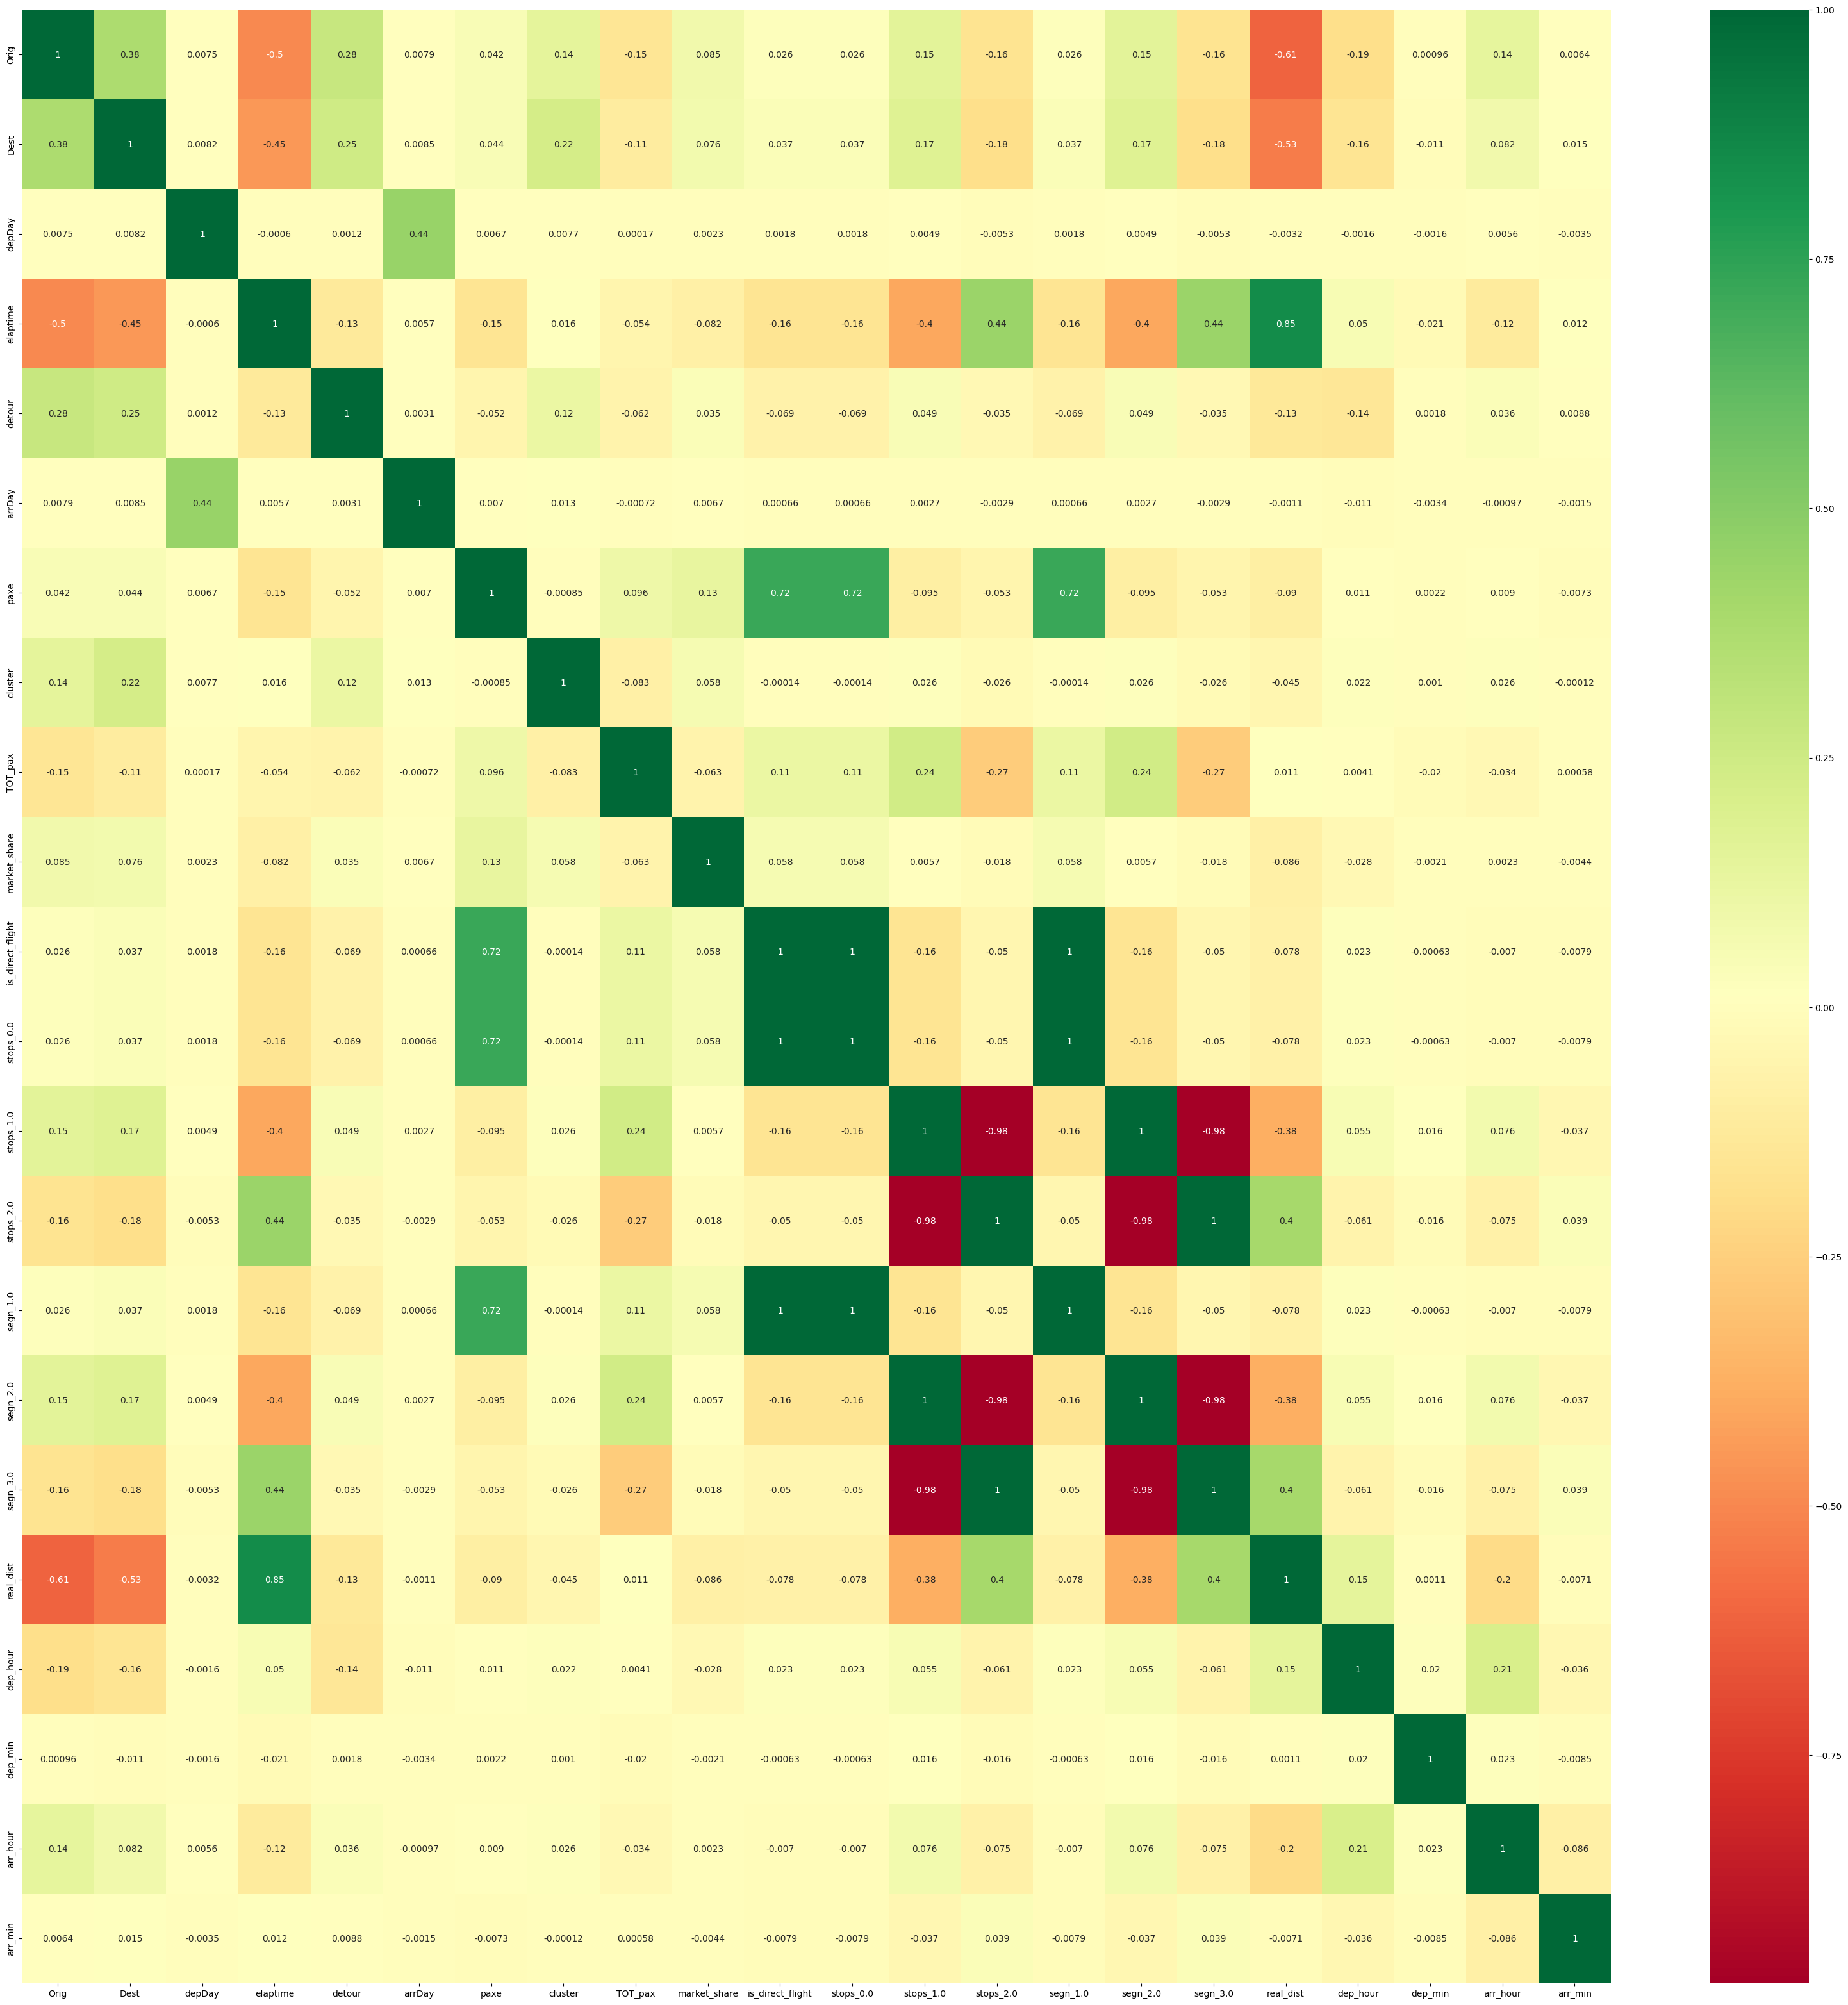

In [49]:
# For the sake of creating a correlation matrix, drop cols with nulls
df_copy = df.copy().drop(columns=['con1', 'con2', 'depDay2', 'depDay3'])

# Finds correlation between Independent and dependent attributes
import seaborn as sns

plt.figure(figsize = (40,40))
sns.heatmap(df_copy.corr(), annot=True, cmap = "RdYlGn")

plt.show()

In [ ]:
# # Important feature using ExtraTreesRegressor
# from sklearn.ensemble import ExtraTreesRegressor

# # Assuming y is a column-vector (n_samples, 1)
# y = y.values.ravel()
# selection = ExtraTreesRegressor()
# selection.fit(X, y)

# print(selection.feature_importances_)

In [ ]:
# #plot graph of feature importances for better visualization

# plt.figure(figsize = (12,8))
# feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
# feat_importances.nlargest(20).plot(kind='barh')
# plt.show()